# Code to generate Figure 6 

In [1]:
%cd ../../src/gz21_ocean_momentum
import os
from utils import select_experiment, select_run
from analysis.utils import plot_dataset, GlobalPlotter
import mlflow
from mlflow.tracking import MlflowClient
import xarray as xr
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm

import cmocean
cmap_solar = cmocean.cm.solar
cmap_balance = cmocean.cm.balance

mlruns_path=os.path.join(os.getcwd(), '../../mlruns')
%env MLFLOW_TRACKING_URI $mlruns_path

plt.rcParams["figure.figsize"] = (4, 4 / 1.618)

/home/marion/workspace/gz21_ocean_momentum/src/gz21_ocean_momentum
To load the net from the paper, use the function load_paper_net().
env: MLFLOW_TRACKING_URI=/home/marion/workspace/gz21_ocean_momentum/src/gz21_ocean_momentum/../../mlruns


## Script parameters

In [2]:
run_control_id = None
run_1pct_id = None
var_name = 'vsurf'
cmap = cmocean.cm.amp


In [3]:
def select_run_id():
    exp_id, exp_name = select_experiment()
    #experiment_id = mlflow.get_experiment_by_name(exp_name).experiment_id
    cols = ['params.CO2', 'params.factor']
    run = select_run(cols=cols, experiment_ids=(exp_id,))
    return run.run_id

In [4]:
ml_client = MlflowClient()
if not run_control_id:
    print("Please select run with CO2=0.")
    run_control_id = select_run_id()
if not run_1pct_id:
    print("Please select run with CO2=1.")
    run_1pct_id = select_run_id()

run_control = mlflow.get_run(run_control_id)
run_1pct = mlflow.get_run(run_1pct_id)

data_control = xr.open_zarr(ml_client.download_artifacts(run_control_id, 'forcing'))
data_1pct = xr.open_zarr(ml_client.download_artifacts(run_1pct_id, 'forcing'))
data_control = data_control.rename(dict(xu_ocean='longitude', yu_ocean='latitude'))
data_1pct = data_1pct.rename(dict(xu_ocean='longitude', yu_ocean='latitude'))

# Rescale the forcing
for var in ('S_x', 'S_y'):
    data_control[var] /= 1e-7
    data_1pct[var] /= 1e-7

# Remove the seasonal means
seasonal_groupby_control = data_control.groupby('time.month').mean()
seasonal_groupby_1pct = data_1pct.groupby('time.month').mean()

data_control = data_control.groupby('time.month') - seasonal_groupby_control
data_1pct = data_1pct.groupby('time.month') - seasonal_groupby_1pct

Please select run with CO2=0.
818272389476453145 :  test5_no_c02
400567430961551461 :  test4
497746281881301089 :  test3
568040818937566888 :  test2
302083951441703666 :  testrun
0 :  Default


Select the id of an experiment:  818272389476453145


                             run_id       experiment_id params.CO2  \
0  b7a595a8c1494d3d952456927f91e8f3  818272389476453145          0   

  params.factor  
0             4  


Select row number (first column) 0


Please select run with CO2=1.
818272389476453145 :  test5_no_c02
400567430961551461 :  test4
497746281881301089 :  test3
568040818937566888 :  test2
302083951441703666 :  testrun
0 :  Default


Select the id of an experiment:  400567430961551461


                             run_id       experiment_id params.CO2  \
0  776f134476b64e6dafb543acb441de55  400567430961551461          1   

  params.factor  
0             4  


Select row number (first column) 0


In [5]:
var_control = data_control[var_name].std(dim='time')
var_1pct = data_1pct[var_name].std(dim='time')
with ProgressBar():
    var_control = var_control.compute()
    var_1pct = var_1pct.compute()

[########################################] | 100% Completed | 1.66 sms
[#####                                   ] | 12% Completed | 104.84 ms

/home/marion/workspace/gz21_ocean_momentum/venv/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 1.66 sms


In [6]:
diff =  var_1pct - var_control
r_diff = diff / var_control

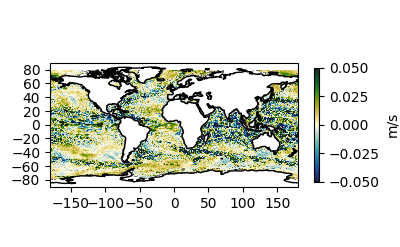

In [7]:
#%matplotlib notebook #this option does not work with jupyterlab
%matplotlib widget
from cartopy.crs import PlateCarree
from data.pangeo_catalog import get_patch, get_whole_data
from scipy.ndimage import gaussian_filter
from matplotlib import colors


CATALOG_URL = 'https://raw.githubusercontent.com/pangeo-data/pangeo-datastore\
/master/intake-catalogs/master.yaml'


plotter = GlobalPlotter(cbar=True, margin=4)
plotter.x_ticks = np.arange(-150., 151., 50)
plotter.y_ticks = np.arange(-80., 81., 20)

ax=plotter.plot(diff, vmin=-0.05, vmax=0.05, cmap=cmocean.cm.delta, lon=0., colorbar_label='m/s')


In [ ]:
plt.savefig('r_diff_' + var_name + '.jpg', dpi=400)

In [ ]:
uv_plotter = plotter
def apply_complete_mask(array):
    mask = uv_plotter.borders
    mask2 = uv_plotter.mask
    mask = mask.interp({k: array.coords[k] for k in ['longitude', 'latitude']})
    mask2 = mask2.interp({k: array.coords[k] for k in ['longitude', 'latitude']})
    array = array.where(np.isnan(mask) & (~np.isnan(mask2)))
    #array = array.sel(latitude=slice(pred['latitude'][0], pred['latitude'][-1]))
    return array
apply_complete_mask(r_diff).sel(latitude=slice(-60, 60)).mean().compute()